# Optimization Methods
Until now, you've always used Gradient Descent to update the parameters and minimize the cost. In this notebook, you will learn more advanced optimization methods that can speed up learning and perhaps even get you to a better final value for the cost function. Having a good optimization algorithm can be the difference between waiting days vs. just a few hours to get a good result.

Gradient descent goes "downhill" on a cost function $J$. Think of it as trying to do this:

**Notations**: As usual, $\frac{\partial J}{\partial a } = $ da for any variable a.

To get started, run the following code to import the libraries you will need.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import math
import sklearn
import sklearn.datasets

from opt_utils import load_params_and_grads, initialize_parameters, forward_propagation, backward_propagation
from opt_utils import compute_cost, predict, predict_dec, plot_decision_boundary, load_dataset
from testCases import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## 1 - Gradient Descent
A simple optimization method in machine learning is gradient descent (GD). When you take gradient steps with respect to all $m$ examples on each step, it is also called Batch Gradient Descent.

**Warm-up exercise**: Implement the gradient descent update rule. The gradient descent rule is, for $l = 1, ..., L$:$$ W^{[l]} = W^{[l]} - \alpha \text{ } dW^{[l]} \tag{1}$$$$ b^{[l]} = b^{[l]} - \alpha \text{ } db^{[l]} \tag{2}$$

where L is the number of layers and $\alpha$ is the learning rate. All parameters should be stored in the parameters dictionary. Note that the iterator l starts at 0 in the for loop while the first parameters are $W^{[1]}$ and $b^{[1]}$. You need to shift l to l+1 when coding.

In [50]:
# GRADED FUNCTION: update_parameters_with_gd

def update_parameters_with_gd(parameters, grads, learning_rate):
    """
    Update parameters using one step of gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters to be updated:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients to update each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    learning_rate -- the learning rate, scalar.
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    """

    L = len(parameters) // 2 # number of layers in the neural networks

    # Update rule for each parameter
    for l in range(L):
        ### START CODE HERE ### (approx. 2 lines)
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads['dW' + str(l+1)]
        parameters["b" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads['db' + str(l+1)]
        ### END CODE HERE ###
    
    return parameters

In [51]:
parameters, grads, learning_rate = update_parameters_with_gd_test_case()

parameters = update_parameters_with_gd(parameters, grads, learning_rate)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[ 1.63535156 -0.62320365 -0.53718766]
 [-1.07799357  0.85639907 -2.29470142]]
b1 = [[ 1.63658046 -0.62197475 -0.53595876]
 [-1.06863587  0.86575676 -2.28534372]]
W2 = [[ 0.32171798 -0.25467393  1.46902454]
 [-2.05617317 -0.31554548 -0.3756023 ]
 [ 1.1404819  -1.09976462 -0.1612551 ]]
b2 = [[ 0.31937382 -0.25701809  1.46668039]
 [-2.0727712  -0.3321435  -0.39220032]
 [ 1.13306146 -1.10718506 -0.16867555]]


A variant of this is Stochastic Gradient Descent (SGD), which is equivalent to mini-batch gradient descent where each mini-batch has just 1 example. The update rule that you have just implemented does not change. What changes is that you would be computing gradients on just one training example at a time, rather than on the whole training set. The code examples below illustrate the difference between stochastic gradient descent and (batch) gradient descent.

- **(Batch) Gradient Descent**:
```
X = data_input
Y = labels
parameters = initialize_parameters(layers_dims)
for i in range(0, num_iterations):
    # Forward propagation
    a, caches = forward_propagation(X, parameters)
    # Compute cost.
    cost = compute_cost(a, Y)
    # Backward propagation.
    grads = backward_propagation(a, caches, parameters)
    # Update parameters.
    parameters = update_parameters(parameters, grads)
```

- **Stochastic Gradient Descent**:
```
X = data_input
Y = labels
parameters = initialize_parameters(layers_dims)
for i in range(0, num_iterations):
    for j in range(0, m):
        # Forward propagation
        a, caches = forward_propagation(X[:,j], parameters)
        # Compute cost
        cost = compute_cost(a, Y[:,j])
        # Backward propagation
        grads = backward_propagation(a, caches, parameters)
        # Update parameters.
        parameters = update_parameters(parameters, grads)
```
In Stochastic Gradient Descent, you use only 1 training example before updating the gradients. When the training set is large, SGD can be faster. But the parameters will "oscillate" toward the minimum rather than converge smoothly. Here is an illustration of this:

**Note** also that implementing SGD requires 3 for-loops in total:

1. Over the number of iterations
2. Over the $m$ training examples
3. Over the layers (to update all parameters, from $(W^{[1]},b^{[1]})$ to $(W^{[L]},b^{[L]})$)

In practice, you'll often get faster results if you do not use neither the whole training set, nor only one training example, to perform each update. Mini-batch gradient descent uses an intermediate number of examples for each step. With mini-batch gradient descent, you loop over the mini-batches instead of looping over individual training examples.

- The difference between gradient descent, mini-batch gradient descent and stochastic gradient descent is the number of examples you use to perform one update step.
- You have to tune a learning rate hyperparameter $\alpha$.
- With a well-turned mini-batch size, usually it outperforms either gradient descent or stochastic gradient descent (particularly when the training set is large).

## 2 - Mini-Batch Gradient descent
Let's learn how to build mini-batches from the training set (X, Y).

There are two steps:

- **Shuffle**: Create a shuffled version of the training set (X, Y) as shown below. Each column of X and Y represents a training example. Note that the random shuffling is done synchronously between X and Y. Such that after the shuffling the $i^{th}$ column of X is the example corresponding to the $i^{th}$ label in Y. The shuffling step ensures that examples will be split randomly into different mini-batches.


- **Partition**: Partition the shuffled (X, Y) into mini-batches of size mini_batch_size (here 64). Note that the number of training examples is not always divisible by mini_batch_size. The last mini batch might be smaller, but you don't need to worry about this. When the final mini-batch is smaller than the full mini_batch_size, it will look like this:


**Exercise**: Implement random_mini_batches. We coded the shuffling part for you. To help you with the partitioning step, we give you the following code that selects the indexes for the $1^{st}$ and $2^{nd}$ mini-batches:
```
first_mini_batch_X = shuffled_X[:, 0 : mini_batch_size]
second_mini_batch_X = shuffled_X[:, mini_batch_size : 2 * mini_batch_size]
...
```
**Note** that the last mini-batch might end up smaller than mini_batch_size=64. Let $\lfloor s \rfloor$ represents $s$ rounded down to the nearest integer (this is math.floor(s) in Python). If the total number of examples is not a multiple of mini_batch_size=64 then there will be $\lfloor \frac{m}{mini\_batch\_size}\rfloor$ mini-batches with a full 64 examples, and the number of examples in the final mini-batch will be ($m-mini_\_batch_\_size \times \lfloor \frac{m}{mini\_batch\_size}\rfloor$).

In [52]:
# GRADED FUNCTION: random_mini_batches

def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    mini_batch_size -- size of the mini-batches, integer
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    np.random.seed(seed)            # To make your "random" minibatches the same as ours
    m = X.shape[1]                  # number of training examples
    mini_batches = []
        
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1,m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        ### START CODE HERE ### (approx. 2 lines)
        mini_batch_X = shuffled_X[:, k*mini_batch_size:(k+1)*mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k*mini_batch_size:(k+1)*mini_batch_size]
        
        ### END CODE HERE ###
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        ### START CODE HERE ### (approx. 2 lines)
        mini_batch_X = shuffled_X[:,num_complete_minibatches * mini_batch_size:]
        mini_batch_Y = shuffled_Y[:,num_complete_minibatches * mini_batch_size:]
        ### END CODE HERE ###
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
        
    return mini_batches

In [53]:
X_assess, Y_assess, mini_batch_size = random_mini_batches_test_case()
mini_batches = random_mini_batches(X_assess, Y_assess, mini_batch_size)

print ("shape of the 1st mini_batch_X: " + str(mini_batches[0][0].shape))
print ("shape of the 2nd mini_batch_X: " + str(mini_batches[1][0].shape))
print ("shape of the 3rd mini_batch_X: " + str(mini_batches[2][0].shape))
print ("shape of the 1st mini_batch_Y: " + str(mini_batches[0][1].shape))
print ("shape of the 2nd mini_batch_Y: " + str(mini_batches[1][1].shape)) 
print ("shape of the 3rd mini_batch_Y: " + str(mini_batches[2][1].shape))
print ("mini batch sanity check: " + str(mini_batches[0][0][0][0:3]))

shape of the 1st mini_batch_X: (12288, 64)
shape of the 2nd mini_batch_X: (12288, 64)
shape of the 3rd mini_batch_X: (12288, 20)
shape of the 1st mini_batch_Y: (1, 64)
shape of the 2nd mini_batch_Y: (1, 64)
shape of the 3rd mini_batch_Y: (1, 20)
mini batch sanity check: [ 0.90085595 -0.7612069   0.2344157 ]


- Shuffling and Partitioning are the two steps required to build mini-batches
- Powers of two are often chosen to be the mini-batch size, e.g., 16, 32, 64, 128.

## 3 - Momentum
Because mini-batch gradient descent makes a parameter update after seeing just a subset of examples, the direction of the update has some variance, and so the path taken by mini-batch gradient descent will "oscillate" toward convergence. Using momentum can reduce these oscillations.

Momentum takes into account the past gradients to smooth out the update. We will store the 'direction' of the previous gradients in the variable $v$. Formally, this will be the exponentially weighted average of the gradient on previous steps. You can also think of $v$ as the "velocity" of a ball rolling downhill, building up speed (and momentum) according to the direction of the gradient/slope of the hill.

In [54]:
# GRADED FUNCTION: initialize_velocity

def initialize_velocity(parameters):
    """
    Initializes the velocity as a python dictionary with:
                - keys: "dW1", "db1", ..., "dWL", "dbL" 
                - values: numpy arrays of zeros of the same shape as the corresponding gradients/parameters.
    Arguments:
    parameters -- python dictionary containing your parameters.
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    
    Returns:
    v -- python dictionary containing the current velocity.
                    v['dW' + str(l)] = velocity of dWl
                    v['db' + str(l)] = velocity of dbl
    """
    
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    
    # Initialize velocity
    for l in range(L):
        ### START CODE HERE ### (approx. 2 lines)
        v["dW" + str(l+1)] = np.zeros_like(parameters['W' + str(l+1)])
        v["db" + str(l+1)] = np.zeros_like(parameters['b' + str(l+1)])
        ### END CODE HERE ###
        
    return v

In [55]:
parameters = initialize_velocity_test_case()

v = initialize_velocity(parameters)
print("v[\"dW1\"] = " + str(v["dW1"]))
print("v[\"db1\"] = " + str(v["db1"]))
print("v[\"dW2\"] = " + str(v["dW2"]))
print("v[\"db2\"] = " + str(v["db2"]))

v["dW1"] = [[0. 0. 0.]
 [0. 0. 0.]]
v["db1"] = [[0.]
 [0.]]
v["dW2"] = [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
v["db2"] = [[0.]
 [0.]
 [0.]]


**Exercise**: Now, implement the parameters update with momentum. The momentum update rule is, for $l = 1, ..., L$:

$$ \begin{cases}
v_{dW^{[l]}} = \beta v_{dW^{[l]}} + (1 - \beta) dW^{[l]} \\
W^{[l]} = W^{[l]} - \alpha v_{dW^{[l]}}
\end{cases}\tag{3}$$$$\begin{cases}
v_{db^{[l]}} = \beta v_{db^{[l]}} + (1 - \beta) db^{[l]} \\
b^{[l]} = b^{[l]} - \alpha v_{db^{[l]}} 
\end{cases}\tag{4}$$
where L is the number of layers, $\beta$ is the momentum and $\alpha$ is the learning rate. All parameters should be stored in the parameters dictionary. Note that the iterator l starts at 0 in the for loop while the first parameters are $W^{[1]}$ and $b^{[1]}$ (that's a "one" on the superscript). So you will need to shift l to l+1 when coding.

In [56]:
# GRADED FUNCTION: update_parameters_with_momentum

def update_parameters_with_momentum(parameters, grads, v, beta, learning_rate):
    """
    Update parameters using Momentum
    
    Arguments:
    parameters -- python dictionary containing your parameters:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients for each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    v -- python dictionary containing the current velocity:
                    v['dW' + str(l)] = ...
                    v['db' + str(l)] = ...
    beta -- the momentum hyperparameter, scalar
    learning_rate -- the learning rate, scalar
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    v -- python dictionary containing your updated velocities
    """

    L = len(parameters) // 2 # number of layers in the neural networks
    
    # Momentum update for each parameter
    for l in range(L):
        
        ### START CODE HERE ### (approx. 4 lines)
        # compute velocities
        v["dW" + str(l+1)] = beta * v["dW" + str(l+1)] + (1-beta) * grads['dW' + str(l+1)]
        v["db" + str(l+1)] = beta * v["db" + str(l+1)] + (1-beta) * grads['db' + str(l+1)]
        # update parameters
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * v['dW' + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * v['db' + str(l+1)]
        ### END CODE HERE ###
    
    return parameters, v

In [57]:
parameters, grads, v = update_parameters_with_momentum_test_case()

parameters, v = update_parameters_with_momentum(parameters, grads, v, beta = 0.9, learning_rate = 0.01)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))
print("v[\"dW1\"] = " + str(v["dW1"]))
print("v[\"db1\"] = " + str(v["db1"]))
print("v[\"dW2\"] = " + str(v["dW2"]))
print("v[\"db2\"] = " + str(v["db2"]))

W1 = [[ 1.62544598 -0.61290114 -0.52907334]
 [-1.07347112  0.86450677 -2.30085497]]
b1 = [[ 1.74493465]
 [-0.76027113]]
W2 = [[ 0.31930698 -0.24990073  1.4627996 ]
 [-2.05974396 -0.32173003 -0.38320915]
 [ 1.13444069 -1.0998786  -0.1713109 ]]
b2 = [[-0.87809283]
 [ 0.04055394]
 [ 0.58207317]]
v["dW1"] = [[-0.11006192  0.11447237  0.09015907]
 [ 0.05024943  0.09008559 -0.06837279]]
v["db1"] = [[-0.01228902]
 [-0.09357694]]
v["dW2"] = [[-0.02678881  0.05303555 -0.06916608]
 [-0.03967535 -0.06871727 -0.08452056]
 [-0.06712461 -0.00126646 -0.11173103]]
v["db2"] = [[0.02344157]
 [0.16598022]
 [0.07420442]]


**Note that**:

- The velocity is initialized with zeros. So the algorithm will take a few iterations to "build up" velocity and start to take bigger steps.
- If $\beta = 0$, then this just becomes standard gradient descent without momentum.

**How do you choose $\beta$?**

- The larger the momentum $\beta$ is, the smoother the update because the more we take the past gradients into account. But if $\beta$ is too big, it could also smooth out the updates too much.
- Common values for $\beta$ range from 0.8 to 0.999. If you don't feel inclined to tune this, $\beta = 0.9$ is often a reasonable default.
- Tuning the optimal $\beta$ for your model might need trying several values to see what works best in term of reducing the value of the cost function $J$.
- Momentum takes past gradients into account to smooth out the steps of gradient descent. It can be applied with batch gradient descent, mini-batch gradient descent or stochastic gradient descent.
- You have to tune a momentum hyperparameter $\beta$ and a learning rate $\alpha$.

## 4 - Adam
Adam is one of the most effective optimization algorithms for training neural networks. It combines ideas from RMSProp (described in lecture) and Momentum.

**How does Adam work?**

1. It calculates an exponentially weighted average of past gradients, and stores it in variables $v$ (before bias correction) and $v^{corrected}$ (with bias correction).
2. It calculates an exponentially weighted average of the squares of the past gradients, and stores it in variables $s$ (before bias correction) and $s^{corrected}$ (with bias correction).
3. It updates parameters in a direction based on combining information from "1" and "2".
The update rule is, for $l = 1, ..., L$:

$$\begin{cases}
v_{dW^{[l]}} = \beta_1 v_{dW^{[l]}} + (1 - \beta_1) \frac{\partial \mathcal{J} }{ \partial W^{[l]} } \\
v^{corrected}_{dW^{[l]}} = \frac{v_{dW^{[l]}}}{1 - (\beta_1)^t} \\
s_{dW^{[l]}} = \beta_2 s_{dW^{[l]}} + (1 - \beta_2) (\frac{\partial \mathcal{J} }{\partial W^{[l]} })^2 \\
s^{corrected}_{dW^{[l]}} = \frac{s_{dW^{[l]}}}{1 - (\beta_1)^t} \\
W^{[l]} = W^{[l]} - \alpha \frac{v^{corrected}_{dW^{[l]}}}{\sqrt{s^{corrected}_{dW^{[l]}}} + \varepsilon}
\end{cases}$$
where:

t counts the number of steps taken of Adam
L is the number of layers
$\beta_1$ and $\beta_2$ are hyperparameters that control the two exponentially weighted averages.
$\alpha$ is the learning rate
$\varepsilon$ is a very small number to avoid dividing by zero
As usual, we will store all parameters in the parameters dictionary

**Exercise**: Initialize the Adam variables $v, s$ which keep track of the past information.

**Instruction**: The variables $v, s$ are python dictionaries that need to be initialized with arrays of zeros. Their keys are the same as for grads, that is: for $l = 1, ..., L$:

```
v["dW" + str(l+1)] = ... #(numpy array of zeros with the same shape as parameters["W" + str(l+1)])
v["db" + str(l+1)] = ... #(numpy array of zeros with the same shape as parameters["b" + str(l+1)])
s["dW" + str(l+1)] = ... #(numpy array of zeros with the same shape as parameters["W" + str(l+1)])
s["db" + str(l+1)] = ... #(numpy array of zeros with the same shape as parameters["b" + str(l+1)])
```

In [58]:
# GRADED FUNCTION: initialize_adam

def initialize_adam(parameters) :
    """
    Initializes v and s as two python dictionaries with:
                - keys: "dW1", "db1", ..., "dWL", "dbL" 
                - values: numpy arrays of zeros of the same shape as the corresponding gradients/parameters.
    
    Arguments:
    parameters -- python dictionary containing your parameters.
                    parameters["W" + str(l)] = Wl
                    parameters["b" + str(l)] = bl
    
    Returns: 
    v -- python dictionary that will contain the exponentially weighted average of the gradient.
                    v["dW" + str(l)] = ...
                    v["db" + str(l)] = ...
    s -- python dictionary that will contain the exponentially weighted average of the squared gradient.
                    s["dW" + str(l)] = ...
                    s["db" + str(l)] = ...

    """
    
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    s = {}
    
    # Initialize v, s. Input: "parameters". Outputs: "v, s".
    for l in range(L):
    ### START CODE HERE ### (approx. 4 lines)
        v["dW" + str(l+1)] = np.zeros_like(parameters["W" + str(l+1)])
        v["db" + str(l+1)] = np.zeros_like(parameters["b" + str(l+1)])
        s["dW" + str(l+1)] = np.zeros_like(parameters["W" + str(l+1)])
        s["db" + str(l+1)] = np.zeros_like(parameters["b" + str(l+1)])
    ### END CODE HERE ###
    
    return v, s

In [59]:
parameters = initialize_adam_test_case()

v, s = initialize_adam(parameters)
print("v[\"dW1\"] = " + str(v["dW1"]))
print("v[\"db1\"] = " + str(v["db1"]))
print("v[\"dW2\"] = " + str(v["dW2"]))
print("v[\"db2\"] = " + str(v["db2"]))
print("s[\"dW1\"] = " + str(s["dW1"]))
print("s[\"db1\"] = " + str(s["db1"]))
print("s[\"dW2\"] = " + str(s["dW2"]))
print("s[\"db2\"] = " + str(s["db2"]))

v["dW1"] = [[0. 0. 0.]
 [0. 0. 0.]]
v["db1"] = [[0.]
 [0.]]
v["dW2"] = [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
v["db2"] = [[0.]
 [0.]
 [0.]]
s["dW1"] = [[0. 0. 0.]
 [0. 0. 0.]]
s["db1"] = [[0.]
 [0.]]
s["dW2"] = [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
s["db2"] = [[0.]
 [0.]
 [0.]]


**Exercise**: Now, implement the parameters update with Adam. Recall the general update rule is, for $l = 1, ..., L$:

$$\begin{cases}
v_{W^{[l]}} = \beta_1 v_{W^{[l]}} + (1 - \beta_1) \frac{\partial J }{ \partial W^{[l]} } \\
v^{corrected}_{W^{[l]}} = \frac{v_{W^{[l]}}}{1 - (\beta_1)^t} \\
s_{W^{[l]}} = \beta_2 s_{W^{[l]}} + (1 - \beta_2) (\frac{\partial J }{\partial W^{[l]} })^2 \\
s^{corrected}_{W^{[l]}} = \frac{s_{W^{[l]}}}{1 - (\beta_2)^t} \\
W^{[l]} = W^{[l]} - \alpha \frac{v^{corrected}_{W^{[l]}}}{\sqrt{s^{corrected}_{W^{[l]}}}+\varepsilon}
\end{cases}$$
**Note** that the iterator l starts at 0 in the for loop while the first parameters are $W^{[1]}$ and $b^{[1]}$. You need to shift l to l+1 when coding.

In [60]:
# GRADED FUNCTION: update_parameters_with_adam

def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate = 0.01,
                                beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):
    """
    Update parameters using Adam
    
    Arguments:
    parameters -- python dictionary containing your parameters:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients for each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    v -- Adam variable, moving average of the first gradient, python dictionary
    s -- Adam variable, moving average of the squared gradient, python dictionary
    learning_rate -- the learning rate, scalar.
    beta1 -- Exponential decay hyperparameter for the first moment estimates 
    beta2 -- Exponential decay hyperparameter for the second moment estimates 
    epsilon -- hyperparameter preventing division by zero in Adam updates

    Returns:
    parameters -- python dictionary containing your updated parameters 
    v -- Adam variable, moving average of the first gradient, python dictionary
    s -- Adam variable, moving average of the squared gradient, python dictionary
    """
    
    L = len(parameters) // 2                 # number of layers in the neural networks
    v_corrected = {}                         # Initializing first moment estimate, python dictionary
    s_corrected = {}                         # Initializing second moment estimate, python dictionary
    
    # Perform Adam update on all parameters
    for l in range(L):
        # Moving average of the gradients. Inputs: "v, grads, beta1". Output: "v".
        ### START CODE HERE ### (approx. 2 lines)
        v["dW" + str(l+1)] = beta1 * v["dW" + str(l+1)] + (1-beta1) * grads["dW" + str(l+1)]
        v["db" + str(l+1)] = beta1 * v["db" + str(l+1)] + (1-beta1) * grads["db" + str(l+1)]
        ### END CODE HERE ###
        
        # Compute bias-corrected first moment estimate. Inputs: "v, beta1, t". Output: "v_corrected".
        ### START CODE HERE ### (approx. 2 lines)
        v_corrected["dW" + str(l+1)] = v["dW" + str(l+1)] / (1 - beta1**t)
        v_corrected["db" + str(l+1)] = v["db" + str(l+1)] / (1 - beta1**t)
        ### END CODE HERE ###
        
        # Moving average of the squared gradients. Inputs: "s, grads, beta2". Output: "s".
        ### START CODE HERE ### (approx. 2 lines)
        s["dW" + str(l+1)] = beta2 * s["dW" + str(l+1)] + (1-beta2) * np.power(grads["dW" + str(l+1)], 2)
        s["db" + str(l+1)] = beta2 * s["db" + str(l+1)] + (1-beta2) * np.power(grads["db" + str(l+1)], 2)
        ### END CODE HERE ###
        
        # Compute bias-corrected second raw moment estimate. Inputs: "s, beta2, t". Output: "s_corrected".
        ### START CODE HERE ### (approx. 2 lines)
        s_corrected["dW" + str(l+1)] = s["dW" + str(l+1)] / (1 - beta2**t)
        s_corrected["db" + str(l+1)] = s["db" + str(l+1)] / (1 - beta2**t)
        ### END CODE HERE ###
        
        # Update parameters. Inputs: "parameters, learning_rate, v_corrected, s_corrected, epsilon". Output: "parameters".
        ### START CODE HERE ### (approx. 2 lines)
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * v_corrected["dW" + str(l+1)] / (np.sqrt(s_corrected["dW" + str(l+1)]) + epsilon)
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * v_corrected["db" + str(l+1)] / (np.sqrt(s_corrected["dW" + str(l+1)]) + epsilon)
        ### END CODE HERE
        
        return parameters, v, s

In [61]:

parameters, grads, v, s = update_parameters_with_adam_test_case()
parameters, v, s  = update_parameters_with_adam(parameters, grads, v, s, t = 2)

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))
print("v[\"dW1\"] = " + str(v["dW1"]))
print("v[\"db1\"] = " + str(v["db1"]))
print("v[\"dW2\"] = " + str(v["dW2"]))
print("v[\"db2\"] = " + str(v["db2"]))
print("s[\"dW1\"] = " + str(s["dW1"]))
print("s[\"db1\"] = " + str(s["db1"]))
print("s[\"dW2\"] = " + str(s["dW2"]))
print("s[\"db2\"] = " + str(s["db2"]))

W1 = [[ 1.63178673 -0.61919778 -0.53561312]
 [-1.08040999  0.85796626 -2.29409733]]
b1 = [[ 1.74564263  1.74561062  1.74582605]
 [-0.74734922 -0.75347714 -0.75102243]]
W2 = [[ 0.3190391  -0.24937038  1.46210794]
 [-2.06014071 -0.3224172  -0.38405435]
 [ 1.13376944 -1.09989127 -0.17242821]]
b2 = [[-0.87785842]
 [ 0.04221375]
 [ 0.58281521]]
v["dW1"] = [[-0.11006192  0.11447237  0.09015907]
 [ 0.05024943  0.09008559 -0.06837279]]
v["db1"] = [[-0.01228902]
 [-0.09357694]]
v["dW2"] = [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
v["db2"] = [[0.]
 [0.]
 [0.]]
s["dW1"] = [[0.00121136 0.00131039 0.00081287]
 [0.0002525  0.00081154 0.00046748]]
s["db1"] = [[1.51020075e-05]
 [8.75664434e-04]]
s["dW2"] = [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
s["db2"] = [[0.]
 [0.]
 [0.]]


You now have three working optimization algorithms (mini-batch gradient descent, Momentum, Adam). Let's implement a model with each of these optimizers and observe the difference.

## 5 - Model with different optimization algorithms
Lets use the following "moons" dataset to test the different optimization methods. (The dataset is named "moons" because the data from each of the two classes looks a bit like a crescent-shaped moon.)

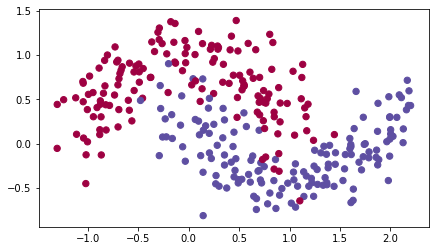

In [63]:
train_X, train_Y = load_dataset()

We have already implemented a 3-layer neural network. You will train it with:

- Mini-batch **Gradient Descent**: it will call your function:
update_parameters_with_gd()
- Mini-batch **Momentum**: it will call your functions:
initialize_velocity() and update_parameters_with_momentum()
- Mini-batch **Adam**: it will call your functions:
initialize_adam() and update_parameters_with_adam()

In [62]:
def model(X, Y, layers_dims, optimizer, learning_rate = 0.0007, mini_batch_size = 64, beta = 0.9,
          beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8, num_epochs = 10000, print_cost = True):
    """
    3-layer neural network model which can be run in different optimizer modes.
    
    Arguments:
    X -- input data, of shape (2, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    layers_dims -- python list, containing the size of each layer
    learning_rate -- the learning rate, scalar.
    mini_batch_size -- the size of a mini batch
    beta -- Momentum hyperparameter
    beta1 -- Exponential decay hyperparameter for the past gradients estimates 
    beta2 -- Exponential decay hyperparameter for the past squared gradients estimates 
    epsilon -- hyperparameter preventing division by zero in Adam updates
    num_epochs -- number of epochs
    print_cost -- True to print the cost every 1000 epochs

    Returns:
    parameters -- python dictionary containing your updated parameters 
    """

    L = len(layers_dims)             # number of layers in the neural networks
    costs = []                       # to keep track of the cost
    t = 0                            # initializing the counter required for Adam update
    seed = 10                        # For grading purposes, so that your "random" minibatches are the same as ours
    
    # Initialize parameters
    parameters = initialize_parameters(layers_dims)

    # Initialize the optimizer
    if optimizer == "gd":
        pass # no initialization required for gradient descent
    elif optimizer == "momentum":
        v = initialize_velocity(parameters)
    elif optimizer == "adam":
        v, s = initialize_adam(parameters)
    
    # Optimization loop
    for i in range(num_epochs):
        
        # Define the random minibatches. We increment the seed to reshuffle differently the dataset after each epoch
        seed = seed + 1
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)

        for minibatch in minibatches:
            # Select a minibatch
            (minibatch_X, minibatch_Y) = minibatch
            
            # Forward propagation
            a3, caches = forward_propagation(minibatch_X, parameters)
            
            # Compute cost
            cost = compute_cost(a3, minibatch_Y)

            # Backward propagation
            grads = backward_propagation(minibatch_X, minibatch_Y, caches)

            # Update parameters
            if optimizer == "gd":
                parameters = update_parameters_with_gd(parameters, grads, learning_rate)
            elif optimizer == "momentum":
                parameters, v = update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
            elif optimizer == "adam":
                t = t + 1 # Adam counter
                parameters, v, s = update_parameters_with_adam(parameters, grads, v, s,
                                                               t, learning_rate, beta1, beta2,  epsilon)
        # Print the cost every 1000 epoch
        if print_cost and i % 1000 == 0:
            print ("Cost after epoch %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
                
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    return parameters

You will now run this 3 layer neural network with each of the 3 optimization methods.

### 5.1 - Mini-batch Gradient descent
Run the following code to see how the model does with mini-batch gradient descent.

In [64]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "gd")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Gradient Descent optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

ValueError: operands could not be broadcast together with shapes (5,64) (5,2) 

### 5.2 - Mini-batch gradient descent with momentum
Run the following code to see how the model does with momentum. Because this example is relatively simple, the gains from using momemtum are small; but for more complex problems you might see bigger gains.

Cost after epoch 0: 0.690741
Cost after epoch 1000: 0.685341
Cost after epoch 2000: 0.647145
Cost after epoch 3000: 0.619594
Cost after epoch 4000: 0.576665
Cost after epoch 5000: 0.607324
Cost after epoch 6000: 0.529476
Cost after epoch 7000: 0.460936
Cost after epoch 8000: 0.465780
Cost after epoch 9000: 0.464740
Accuracy: 0.7966666666666666


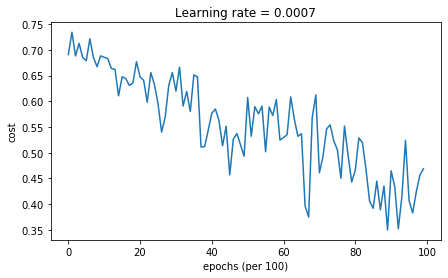

ValueError: 'c' argument has 1 elements, which is not acceptable for use with 'x' with size 300, 'y' with size 300.

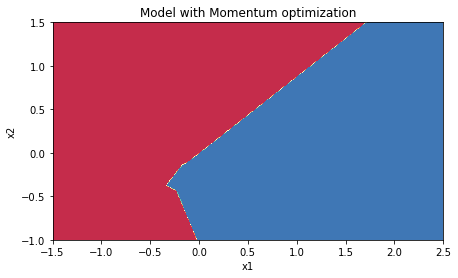

In [65]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, beta = 0.9, optimizer = "momentum")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Momentum optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

### 5.3 - Mini-batch with Adam mode
Run the following code to see how the model does with Adam.

In [67]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "adam")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Adam optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

ValueError: operands could not be broadcast together with shapes (5,64) (5,2) 